In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Install necessary packages
!pip install scikit-image PyWavelets

# Import libraries
import os
import cv2
import numpy as np
import time
import matplotlib.pyplot as plt
from skimage.restoration import denoise_wavelet
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error as mse
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from google.colab import files


Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 61.0 MB/s eta 0:00:00


In [ ]:
# Step 1: Download the dataset
!gdown --id 157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB

# Step 2: Unzip the dataset
!unzip -q LOLdataset.zip -d /content/  # Extracting into /content/

# Step 3: Check the dataset structure
import os

DATASET_PATH = "/content/LOLDataset"  # Update this if the folder name is different

if os.path.exists(DATASET_PATH):
    print("✅ Dataset extracted successfully!")

    # Check folder structure
    print("Contents of dataset:", os.listdir(DATASET_PATH))

    # Define paths
    our485_path = os.path.join(DATASET_PATH, "our485")
    eval15_path = os.path.join(DATASET_PATH, "eval15")

    # Check if folders exist
    if os.path.exists(our485_path):
        print("Our485 - Low light images:", os.listdir(os.path.join(our485_path, "low"))[:5])
        print("Our485 - High light images:", os.listdir(os.path.join(our485_path, "high"))[:5])
    else:
        print("❌ Error: 'our485' folder not found!")

    if os.path.exists(eval15_path):
        print("Eval15 - Low light images:", os.listdir(os.path.join(eval15_path, "low"))[:5])
        print("Eval15 - High light images:", os.listdir(os.path.join(eval15_path, "high"))[:5])
    else:
        print("❌ Error: 'eval15' folder not found!")

else:
    print("❌ Error: Dataset not found! Check if the ZIP file was downloaded correctly.")


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB
From (redirected): https://drive.google.com/uc?id=157bjO1_cFuSd0HWDUuAmcHRJDVyWpOxB&confirm=t&uuid=4ae36b4d-a927-4b26-95fc-3457e29dac22
To: /content/LOLdataset.zip
100% 347M/347M [00:04<00:00, 73.9MB/s]
❌ Error: Dataset not found! Check if the ZIP file was downloaded correctly.


In [ ]:
# Define dataset paths
DATASET_PATH = "/content"  # Update this path as needed
TRAIN_LOW_PATH = os.path.join(DATASET_PATH, "our485", "low")
TRAIN_HIGH_PATH = os.path.join(DATASET_PATH, "our485", "high")
TEST_LOW_PATH = os.path.join(DATASET_PATH, "eval15", "low")
TEST_HIGH_PATH = os.path.join(DATASET_PATH, "eval15", "high")

# Image size
IMG_SIZE = (256, 256)

# Function to load and preprocess images
def load_images(folder, img_size=IMG_SIZE):
    images = []
    for filename in os.listdir(folder):
        img_path = os.path.join(folder, filename)
        img = cv2.imread(img_path)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize to [0,1]
            images.append(img)
    return np.array(images)

# Load images
train_low = load_images(TRAIN_LOW_PATH)
train_high = load_images(TRAIN_HIGH_PATH)
test_low = load_images(TEST_LOW_PATH)
test_high = load_images(TEST_HIGH_PATH)

# Apply wavelet denoising
def wavelet_denoising(img):
    return denoise_wavelet(img, channel_axis=-1, convert2ycbcr=True, method='BayesShrink', mode='soft')

train_low = np.array([wavelet_denoising(img) for img in train_low])
test_low = np.array([wavelet_denoising(img) for img in test_low])


In [ ]:
def unet_model(input_shape=(256, 256, 3)):
    inputs = Input(input_shape)

    # Encoder (LeNet-inspired)
    c1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    p1 = MaxPooling2D((2, 2))(c1)
    c2 = Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    p2 = MaxPooling2D((2, 2))(c2)
    c3 = Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation='relu', padding='same')(p3)

    # Decoder
    u1 = UpSampling2D((2, 2))(c4)
    m1 = Concatenate()([u1, c3])
    c5 = Conv2D(256, (3, 3), activation='relu', padding='same')(m1)

    u2 = UpSampling2D((2, 2))(c5)
    m2 = Concatenate()([u2, c2])
    c6 = Conv2D(128, (3, 3), activation='relu', padding='same')(m2)

    u3 = UpSampling2D((2, 2))(c6)
    m3 = Concatenate()([u3, c1])
    c7 = Conv2D(64, (3, 3), activation='relu', padding='same')(m3)

    # Output Layer
    outputs = Conv2D(3, (3, 3), activation='sigmoid', padding='same')(c7)

    model = Model(inputs, outputs)
    return model


In [ ]:
# SSIM loss function
def ssim_loss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Training function
def train_model(epochs, save_path):
    model = unet_model()
    model.compile(optimizer='adam', loss=ssim_loss, metrics=['accuracy'])

    start_time = time.time()
    history = model.fit(train_low, train_high, epochs=epochs, batch_size=8, validation_split=0.2)
    end_time = time.time()

    training_duration = end_time - start_time
    print(f"Training completed in {training_duration:.2f} seconds ({training_duration/60:.2f} minutes)")

    # Save the model
    model.save(save_path)

    # Plot loss curves
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss for {epochs} Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model


In [ ]:
model_path_10 = "/content/drive/MyDrive/train_model/low_light_enhancement_unet_10.h5"
model_path_25 = "/content/drive/MyDrive/train_model/low_light_enhancement_unet_25.h5"
model_path_50 = "/content/drive/MyDrive/train_model/low_light_enhancement_unet_50.h5"


Epoch 1/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 66s 789ms/step - accuracy: 0.4899 - loss: 0.3813 - val_accuracy: 0.4091 - val_loss: 0.2675
Epoch 2/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 247ms/step - accuracy: 0.5568 - loss: 0.2358 - val_accuracy: 0.7032 - val_loss: 0.1805
Epoch 3/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 243ms/step - accuracy: 0.7182 - loss: 0.2018 - val_accuracy: 0.7569 - val_loss: 0.1736
Epoch 4/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step - accuracy: 0.7349 - loss: 0.1911 - val_accuracy: 0.7613 - val_loss: 0.1663
Epoch 5/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - accuracy: 0.7358 - loss: 0.1906 - val_accuracy: 0.7708 - val_loss: 0.1638
Epoch 6/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 247ms/step - accuracy: 0.7223 - loss: 0.1825 - val_accuracy: 0.7686 - val_loss: 0.1596
Epoch 7/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 247ms/step - accuracy: 0.7187 - loss: 0.1800 - val_accuracy: 0.7511 - val_loss: 0.1571
Epoch 8/10
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 248ms/step - accuracy: 0.7280 - loss: 0.1770 - val_accu

Training completed in 226.85 seconds (3.78 minutes)


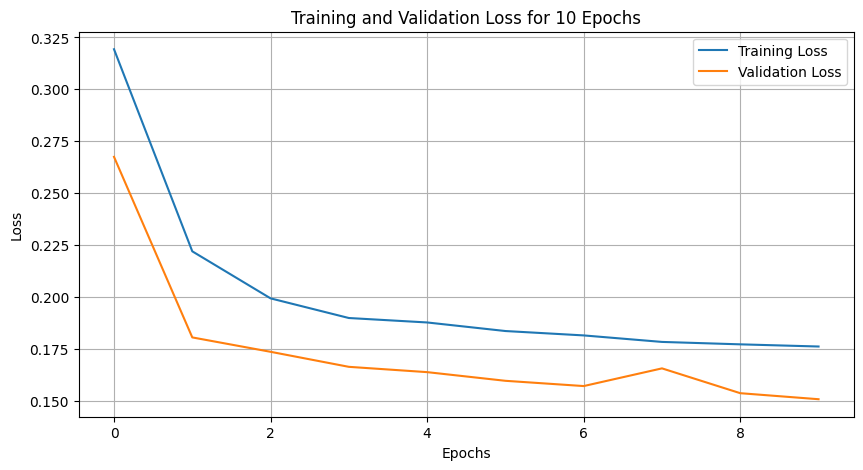

Epoch 1/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 342ms/step - accuracy: 0.4834 - loss: 0.4144 - val_accuracy: 0.6293 - val_loss: 0.2293
Epoch 2/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step - accuracy: 0.5903 - loss: 0.2308 - val_accuracy: 0.4652 - val_loss: 0.1917
Epoch 3/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: 0.6981 - loss: 0.1945 - val_accuracy: 0.7186 - val_loss: 0.1652
Epoch 4/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 242ms/step - accuracy: 0.7180 - loss: 0.1918 - val_accuracy: 0.7546 - val_loss: 0.1694
Epoch 5/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 248ms/step - accuracy: 0.7345 - loss: 0.1832 - val_accuracy: 0.6680 - val_loss: 0.1617
Epoch 6/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 254ms/step - accuracy: 0.7332 - loss: 0.1843 - val_accuracy: 0.7147 - val_loss: 0.1564
Epoch 7/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 242ms/step - accuracy: 0.7176 - loss: 0.1787 - val_accuracy: 0.6898 - val_loss: 0.1710
Epoch 8/25
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 243ms/step - accuracy: 0.7205 - loss: 0.1746 - val_accu

Training completed in 440.22 seconds (7.34 minutes)


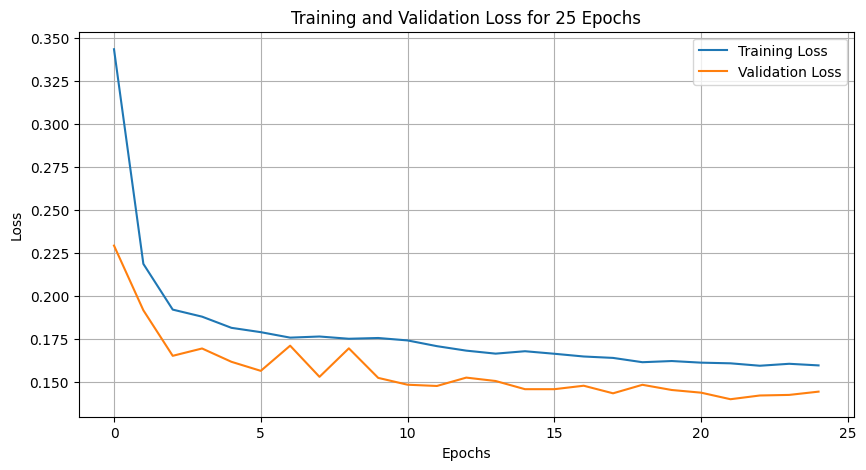

Epoch 1/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 24s 327ms/step - accuracy: 0.4558 - loss: 0.3953 - val_accuracy: 0.4531 - val_loss: 0.2106
Epoch 2/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 13s 241ms/step - accuracy: 0.5172 - loss: 0.2244 - val_accuracy: 0.6782 - val_loss: 0.1763
Epoch 3/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 12s 250ms/step - accuracy: 0.7165 - loss: 0.1935 - val_accuracy: 0.6146 - val_loss: 0.1701
Epoch 4/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 248ms/step - accuracy: 0.7085 - loss: 0.1908 - val_accuracy: 0.7348 - val_loss: 0.1617
Epoch 5/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 249ms/step - accuracy: 0.7291 - loss: 0.1837 - val_accuracy: 0.7463 - val_loss: 0.1674
Epoch 6/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 244ms/step - accuracy: 0.7203 - loss: 0.1826 - val_accuracy: 0.6637 - val_loss: 0.1552
Epoch 7/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 243ms/step - accuracy: 0.7199 - loss: 0.1908 - val_accuracy: 0.7490 - val_loss: 0.1574
Epoch 8/50
49/49 ━━━━━━━━━━━━━━━━━━━━ 20s 241ms/step - accuracy: 0.7274 - loss: 0.1748 - val_accu

Training completed in 902.13 seconds (15.04 minutes)


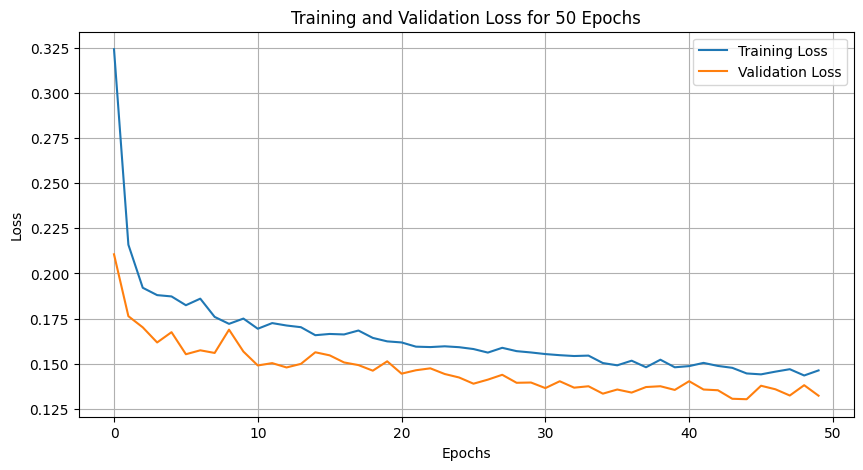

In [ ]:
# Train and save model for 10 epochs
model_10 = train_model(epochs=10, save_path=model_path_10)

# Train and save model for 25 epochs
model_25 = train_model(epochs=25, save_path=model_path_25)

# Train and save model for 50 epochs
model_50 = train_model(epochs=50, save_path=model_path_50)


In [ ]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from sklearn.metrics import mean_squared_error as mse
import numpy as np

def evaluate_model(model, test_low, test_high):
    ssim_scores = []
    psnr_scores = []
    mse_scores = []

    for low_img, high_img in zip(test_low, test_high):
        # Prepare the input image
        low_img_input = np.expand_dims(low_img, axis=0)

        # Predict the enhanced image
        pred_img = model.predict(low_img_input)[0]

        # Ensure the images are in the correct range
        pred_img = np.clip(pred_img, 0, 1)
        high_img = np.clip(high_img, 0, 1)

        # Compute metrics
        ssim_score = ssim(high_img, pred_img, data_range=1.0, channel_axis=-1)
        psnr_score = psnr(high_img, pred_img, data_range=1.0)

        # Flatten the images before computing MSE
        mse_score = mse(high_img.flatten(), pred_img.flatten())

        ssim_scores.append(ssim_score)
        psnr_scores.append(psnr_score)
        mse_scores.append(mse_score)

    # Calculate average metrics
    avg_ssim = np.mean(ssim_scores)
    avg_psnr = np.mean(psnr_scores)
    avg_mse = np.mean(mse_scores)

    print(f"Average SSIM: {avg_ssim:.4f}")
    print(f"Average PSNR: {avg_psnr:.2f} dB")
    print(f"Average MSE: {avg_mse:.6f}")


In [ ]:
print("Evaluating model trained for 10 epochs:")
evaluate_model(model_10, test_low, test_high)

print("\nEvaluating model trained for 25 epochs:")
evaluate_model(model_25, test_low, test_high)

print("\nEvaluating model trained for 50 epochs:")
evaluate_model(model_50, test_low, test_high)


Evaluating model trained for 10 epochs:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
Average SSIM: 0.8098
Average PSNR: 19.20 dB
Average MSE: 0.018629

Evaluating model trained for 25 epochs:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 684ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_comparison_with_ground_truth(model_10, model_25, model_50, test_low, test_high, index=0):
    """
    Visualize low-light input, enhanced outputs from 10, 25, and 50 epoch models, and ground truth image.
    """
    # Get the input image and ground truth
    low_img = test_low[index]
    high_img = test_high[index]
    low_img_input = np.expand_dims(low_img, axis=0)

    # Predict using all models
    pred_10 = model_10.predict(low_img_input)[0]
    pred_25 = model_25.predict(low_img_input)[0]
    pred_50 = model_50.predict(low_img_input)[0]

    # Clip outputs to valid range
    pred_10 = np.clip(pred_10, 0, 1)
    pred_25 = np.clip(pred_25, 0, 1)
    pred_50 = np.clip(pred_50, 0, 1)

    # Plot everything
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 5, 1)
    plt.imshow(low_img)
    plt.title('Original (Low-Light)')
    plt.axis('off')

    plt.subplot(1, 5, 2)
    plt.imshow(pred_10)
    plt.title('Enhanced(10 Epochs)')
    plt.axis('off')

    plt.subplot(1, 5, 3)
    plt.imshow(pred_25)
    plt.title('Enhanced(25 Epochs)')
    plt.axis('off')

    plt.subplot(1, 5, 4)
    plt.imshow(pred_50)
    plt.title('Enhanced(50 Epochs)')
    plt.axis('off')

    plt.subplot(1, 5, 5)
    plt.imshow(high_img)
    plt.title('Ground Truth (Bright)')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# ✅ Call the function
visualize_comparison_with_ground_truth(model_10, model_25, model_50, test_low, test_high, index=0)
visualize_comparison_with_ground_truth(model_10, model_25, model_50, test_low, test_high, index=1)
visualize_comparison_with_ground_truth(model_10, model_25, model_50, test_low, test_high, index=2)
visualize_comparison_with_ground_truth(model_10, model_25, model_50, test_low, test_high, index=3)
visualize_comparison_with_ground_truth(model_10, model_25, model_50, test_low, test_high, index=4)
visualize_comparison_with_ground_truth(model_10, model_25, model_50, test_low, test_high, index=5)
visualize_comparison_with_ground_truth(model_10, model_25, model_50, test_low, test_high, index=6)
visualize_comparison_with_ground_truth(model_10, model_25, model_50, test_low, test_high, index=7)
visualize_comparison_with_ground_truth(model_10, model_25, model_50, test_low, test_high, index=8)
visualize_comparison_with_ground_truth(model_10, model_25, model_50, test_low, test_high, index=9)
visualize_comparison_with_ground_truth(model_10, model_25, model_50, test_low, test_high, index=10)
visualize_comparison_with_ground_truth(model_10, model_25, model_50, test_low, test_high, index=11)
visualize_comparison_with_ground_truth(model_10, model_25, model_50, test_low, test_high, index=12)
visualize_comparison_with_ground_truth(model_10, model_25, model_50, test_low, test_high, index=13)
visualize_comparison_with_ground_truth(model_10, model_25, model_50, test_low, test_high, index=14)




Output hidden; open in https://colab.research.google.com to view.

In [ ]:
from google.colab import files
uploaded = files.upload()


Saving tablet wallpaper thing.jpg to tablet wallpaper thing (1).jpg


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 960ms/step


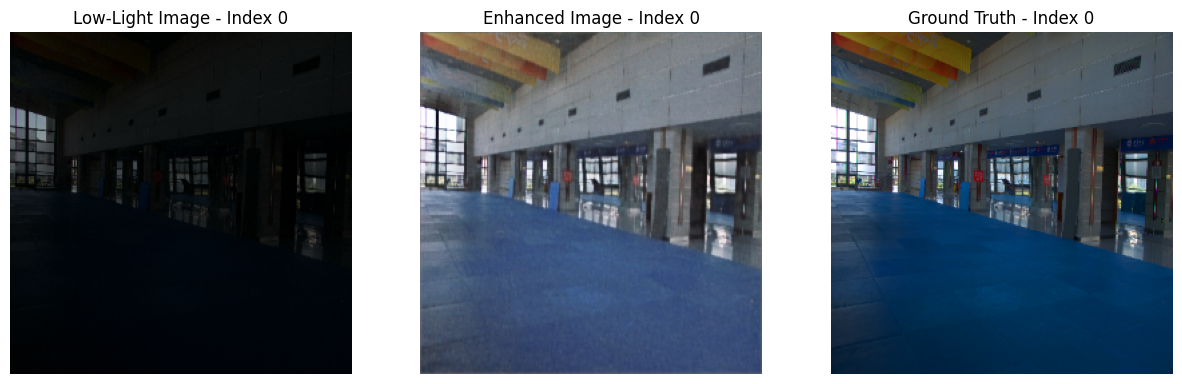

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


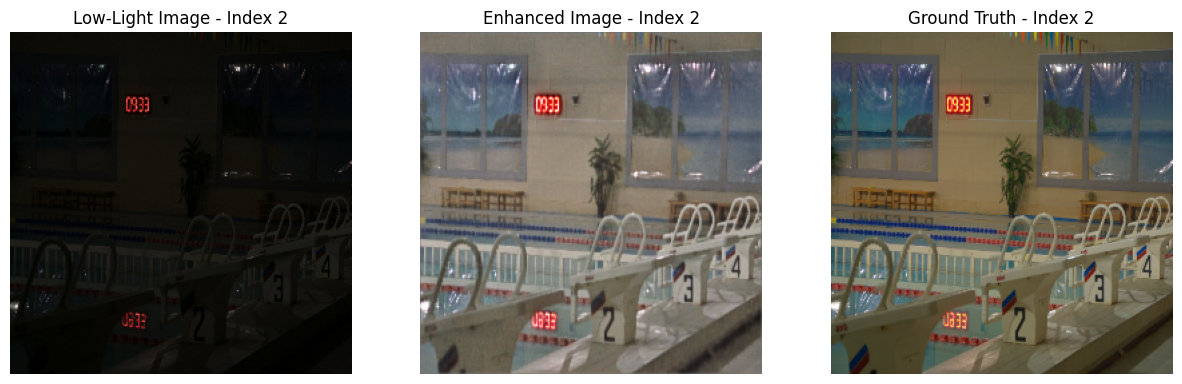

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


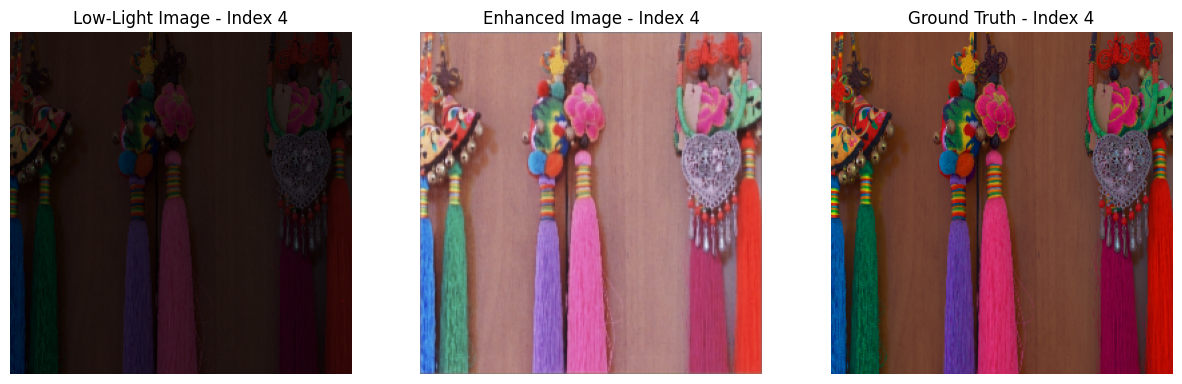

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def enhance_and_visualize(model, test_low, test_high, indices=None):
    # If no specific indices are given, enhance all images
    if indices is None:
        indices = range(len(test_low))

    # Loop through the specified indices (or all if indices is None)
    for index in indices:
        low_img = test_low[index]
        high_img = test_high[index]

        # Predict the enhanced image
        low_img_input = np.expand_dims(low_img, axis=0)  # Expand dims for batch
        enhanced_img = model.predict(low_img_input)[0]  # Model prediction
        enhanced_img = np.clip(enhanced_img, 0, 1)  # Clip to ensure valid range

        # Display the images
        plt.figure(figsize=(15, 5))

        # Show low-light image
        plt.subplot(1, 3, 1)
        plt.imshow(low_img)
        plt.title(f'Low-Light Image - Index {index}')
        plt.axis('off')

        # Show enhanced image
        plt.subplot(1, 3, 2)
        plt.imshow(enhanced_img)
        plt.title(f'Enhanced Image - Index {index}')
        plt.axis('off')

        # Show ground truth high-light image
        plt.subplot(1, 3, 3)
        plt.imshow(high_img)
        plt.title(f'Ground Truth - Index {index}')
        plt.axis('off')

        # Display the images
        plt.show()

# Example: Enhance and visualize multiple images from the test set
# You can specify a list of indices (e.g., [0, 2, 4]) or leave it empty to enhance all images.
enhance_and_visualize(model_10, test_low, test_high, indices=[0, 2, 4])  # Example for indices 0, 2, 4


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving tablet wallpaper thing.jpg to tablet wallpaper thing (3).jpg


In [ ]:
import cv2
import numpy as np

# Replace 'your_image.jpg' with the actual filename
image_path = 'tablet wallpaper thing.jpg'

# Load the image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Resize to match model input size
img_resized = cv2.resize(img, (256, 256))

# Normalize pixel values
img_normalized = img_resized / 255.0

# Expand dimensions to match model input shape
input_img = np.expand_dims(img_normalized, axis=0)


In [ ]:
from tensorflow.keras.models import load_model

# Load models
model_10 = load_model('/content/drive/MyDrive/train_model/low_light_enhancement_unet_10.h5', compile=False)
model_25 = load_model('/content/drive/MyDrive/train_model/low_light_enhancement_unet_25.h5', compile=False)
model_50 = load_model('/content/drive/MyDrive/train_model/low_light_enhancement_unet_50.h5', compile=False)

# Predict enhanced images
enhanced_10 = model_10.predict(input_img)[0]
enhanced_25 = model_25.predict(input_img)[0]
enhanced_50 = model_50.predict(input_img)[0]

# Clip values to [0, 1] and convert to uint8
enhanced_10 = np.clip(enhanced_10, 0, 1)
enhanced_25 = np.clip(enhanced_25, 0, 1)
enhanced_50 = np.clip(enhanced_50, 0, 1)

enhanced_10_uint8 = (enhanced_10 * 255).astype(np.uint8)
enhanced_25_uint8 = (enhanced_25 * 255).astype(np.uint8)
enhanced_50_uint8 = (enhanced_50 * 255).astype(np.uint8)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 553ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step


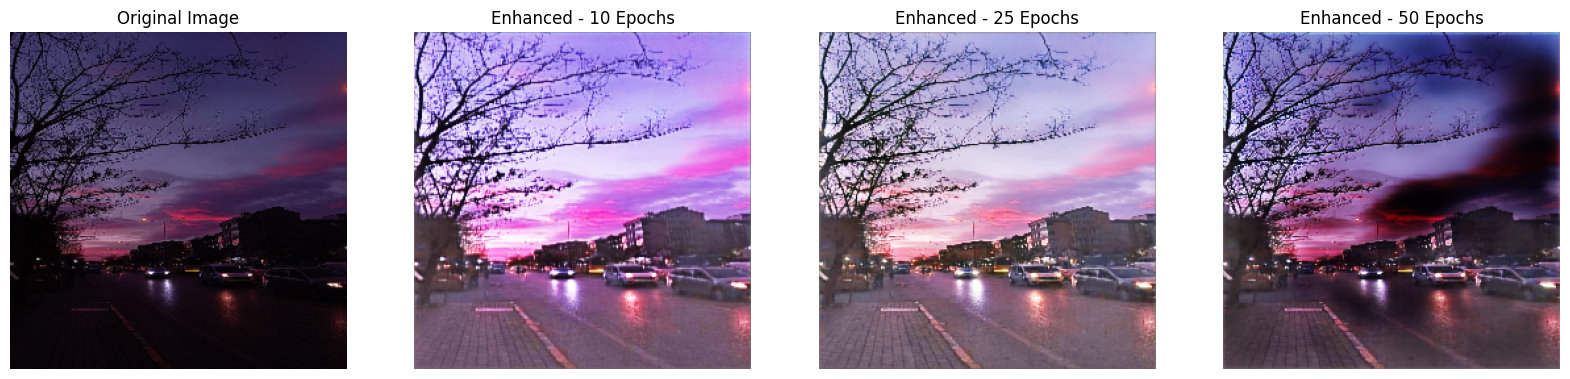

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 5))

# Original Image
plt.subplot(1, 4, 1)
plt.imshow(img_resized)
plt.title('Original Image')
plt.axis('off')

# Enhanced by Model 10
plt.subplot(1, 4, 2)
plt.imshow(enhanced_10_uint8)
plt.title('Enhanced - 10 Epochs')
plt.axis('off')

# Enhanced by Model 25
plt.subplot(1, 4, 3)
plt.imshow(enhanced_25_uint8)
plt.title('Enhanced - 25 Epochs')
plt.axis('off')

# Enhanced by Model 50
plt.subplot(1, 4, 4)
plt.imshow(enhanced_50_uint8)
plt.title('Enhanced - 50 Epochs')
plt.axis('off')

plt.show()


Saving #luxembourg #night.jpg to #luxembourg #night.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 804ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 822ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 639ms/step


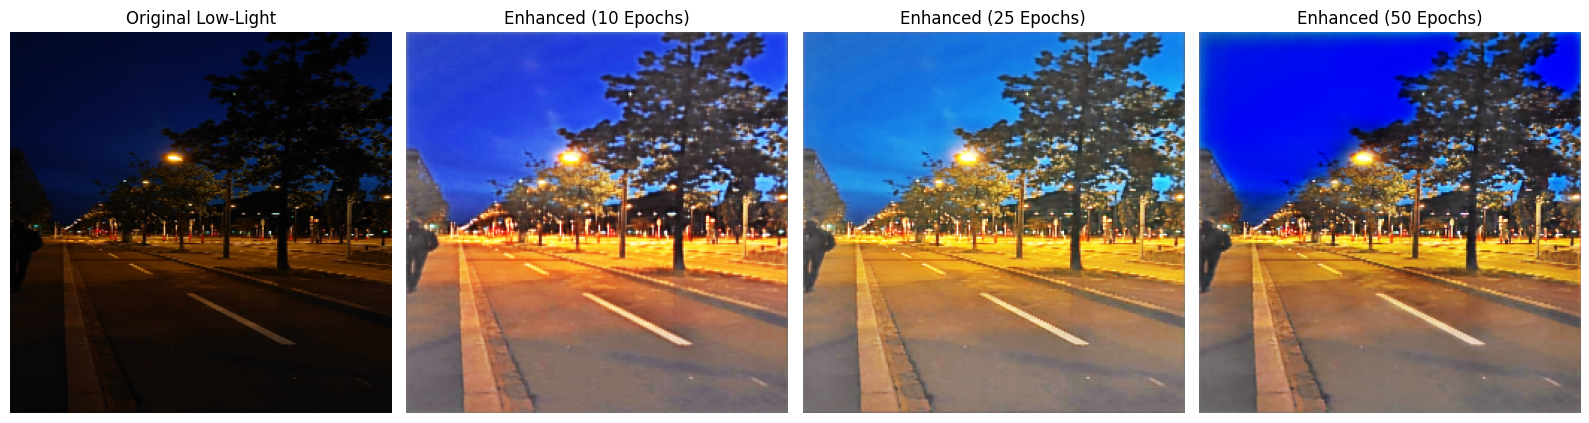

In [ ]:
# Step 1: Upload image from desktop
from google.colab import files
uploaded = files.upload()

# Step 2: Import required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Step 3: Define image preprocessing function
def preprocess_input_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Step 4: Load uploaded image
input_image_path = list(uploaded.keys())[0]
input_img = preprocess_input_image(input_image_path)

# Step 5: Load trained models
model_10 = load_model('/content/drive/MyDrive/train_model/low_light_enhancement_unet_10.h5', compile=False)
model_25 = load_model('/content/drive/MyDrive/train_model/low_light_enhancement_unet_25.h5', compile=False)
model_50 = load_model('/content/drive/MyDrive/train_model/low_light_enhancement_unet_50.h5', compile=False)

# Step 6: Predict enhanced images
enhanced_10 = model_10.predict(input_img)[0]
enhanced_25 = model_25.predict(input_img)[0]
enhanced_50 = model_50.predict(input_img)[0]

# Step 7: Postprocess outputs
enhanced_10 = np.clip(enhanced_10, 0, 1)
enhanced_25 = np.clip(enhanced_25, 0, 1)
enhanced_50 = np.clip(enhanced_50, 0, 1)

# Step 8: Display results
plt.figure(figsize=(16, 6))

# Original
original_img = cv2.imread(input_image_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img = cv2.resize(original_img, (256, 256))

plt.subplot(1, 4, 1)
plt.imshow(original_img)
plt.title("Original Low-Light")
plt.axis("off")

# Enhanced - 10 epochs
plt.subplot(1, 4, 2)
plt.imshow(enhanced_10)
plt.title("Enhanced (10 Epochs)")
plt.axis("off")

# Enhanced - 25 epochs
plt.subplot(1, 4, 3)
plt.imshow(enhanced_25)
plt.title("Enhanced (25 Epochs)")
plt.axis("off")

# Enhanced - 50 epochs
plt.subplot(1, 4, 4)
plt.imshow(enhanced_50)
plt.title("Enhanced (50 Epochs)")
plt.axis("off")

plt.tight_layout()
plt.show()


Saving real world.jpg to real world.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step


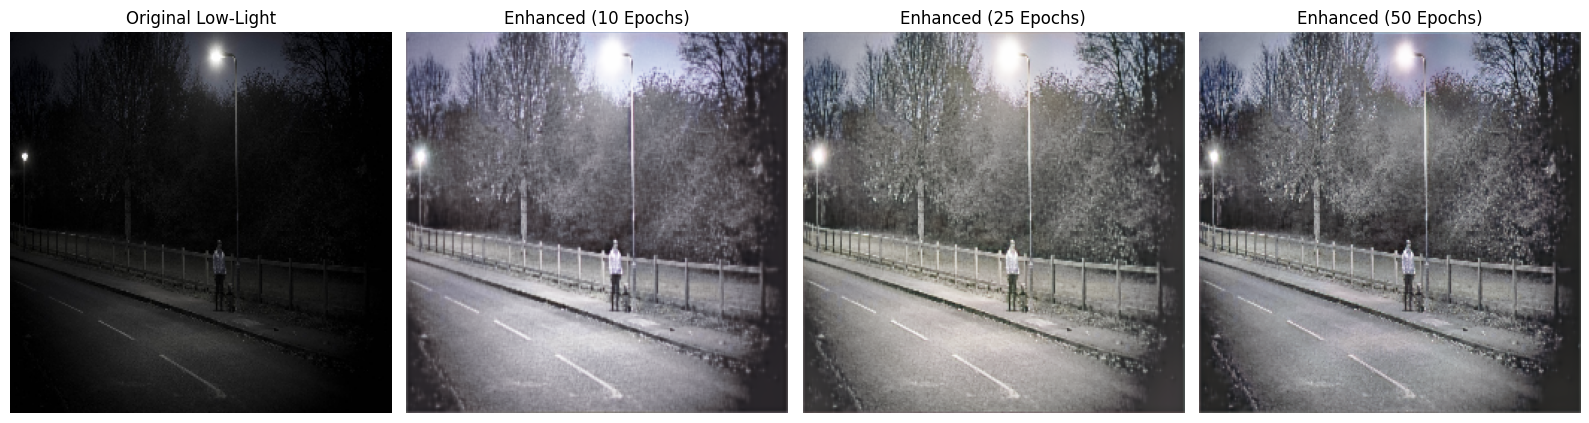

In [ ]:
# Step 1: Upload image from desktop
from google.colab import files
uploaded = files.upload()

# Step 2: Import required libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

# Step 3: Define image preprocessing function
def preprocess_input_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (256, 256))
    img = img / 255.0  # Normalize
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Step 4: Load uploaded image
input_image_path = list(uploaded.keys())[0]
input_img = preprocess_input_image(input_image_path)

# Step 5: Load trained models
model_10 = load_model('/content/drive/MyDrive/train_model/low_light_enhancement_unet_10.h5', compile=False)
model_25 = load_model('/content/drive/MyDrive/train_model/low_light_enhancement_unet_25.h5', compile=False)
model_50 = load_model('/content/drive/MyDrive/train_model/low_light_enhancement_unet_50.h5', compile=False)

# Step 6: Predict enhanced images
enhanced_10 = model_10.predict(input_img)[0]
enhanced_25 = model_25.predict(input_img)[0]
enhanced_50 = model_50.predict(input_img)[0]

# Step 7: Postprocess outputs
enhanced_10 = np.clip(enhanced_10, 0, 1)
enhanced_25 = np.clip(enhanced_25, 0, 1)
enhanced_50 = np.clip(enhanced_50, 0, 1)

# Step 8: Display results
plt.figure(figsize=(16, 6))

# Original
original_img = cv2.imread(input_image_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
original_img = cv2.resize(original_img, (256, 256))

plt.subplot(1, 4, 1)
plt.imshow(original_img)
plt.title("Original Low-Light")
plt.axis("off")

# Enhanced - 10 epochs
plt.subplot(1, 4, 2)
plt.imshow(enhanced_10)
plt.title("Enhanced (10 Epochs)")
plt.axis("off")

# Enhanced - 25 epochs
plt.subplot(1, 4, 3)
plt.imshow(enhanced_25)
plt.title("Enhanced (25 Epochs)")
plt.axis("off")

# Enhanced - 50 epochs
plt.subplot(1, 4, 4)
plt.imshow(enhanced_50)
plt.title("Enhanced (50 Epochs)")
plt.axis("off")

plt.tight_layout()
plt.show()
